In [1]:
pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 7.1 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('/content/Attrition data.csv')
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,3,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,4,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,5,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [4]:
df.shape

(4410, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   Age                      4410 non-null   int64  
 2   Attrition                4410 non-null   object 
 3   BusinessTravel           4410 non-null   object 
 4   Department               4410 non-null   object 
 5   DistanceFromHome         4410 non-null   int64  
 6   Education                4410 non-null   int64  
 7   EducationField           4410 non-null   object 
 8   EmployeeCount            4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [6]:
df.describe(include='all')

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410,4410,4410,4410.000000,4410.000000,4410,4410.0,4410,...,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
unique,NaN,NaN,2,3,3,NaN,NaN,6,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,NaN,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3699,3129,2883,NaN,NaN,1818,NaN,2646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2205.500000,36.923810,NaN,NaN,NaN,9.192517,2.912925,NaN,1.0,NaN,...,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,1273.201673,9.133301,NaN,NaN,NaN,8.105026,1.023933,NaN,0.0,NaN,...,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,1.000000,18.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,1.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,1103.250000,30.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,1.0,NaN,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,2205.500000,36.000000,NaN,NaN,NaN,7.000000,3.000000,NaN,1.0,NaN,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3307.750000,43.000000,NaN,NaN,NaN,14.000000,4.000000,NaN,1.0,NaN,...,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000


In [7]:
df['Attrition'].value_counts()

,count
Attrition,
No,3699
Yes,711


In [8]:
df['Attrition'].value_counts(normalize=True)

,proportion
Attrition,
No,0.838776
Yes,0.161224


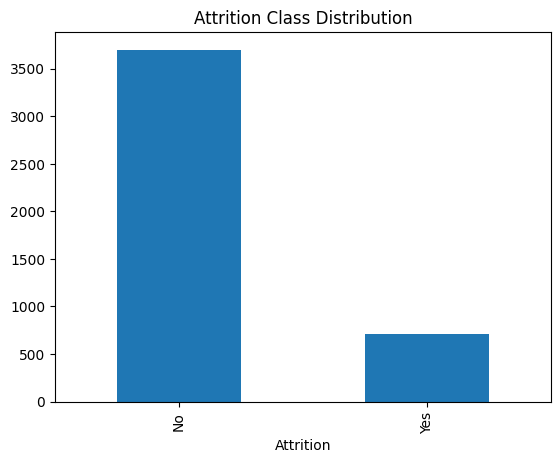

In [9]:

plt.figure()
df['Attrition'].value_counts().plot(kind='bar')
plt.title("Attrition Class Distribution")
plt.show()


In [10]:
df.isnull().sum()

,0
EmployeeID,0
Age,0
Attrition,0
BusinessTravel,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
Gender,0


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:

df = df.drop_duplicates()

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()


,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1,51,0,2,2,6,2,1,1,0,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,31,1,1,1,10,1,1,1,0,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,3,32,0,1,1,17,4,4,1,1,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,4,38,0,0,1,2,5,1,1,1,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,5,32,0,2,1,10,1,3,1,1,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


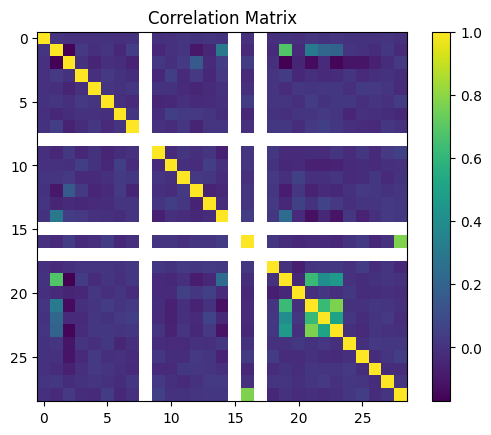

In [13]:

corr = df.corr()

plt.figure()
plt.imshow(corr)
plt.title("Correlation Matrix")
plt.colorbar()
plt.show()


In [16]:
# Check missing values before MI
print("Missing values before handling:")
print(X_temp.isnull().sum().sort_values(ascending=False).head())

# Simple but proper imputation
for col in X_temp.columns:
    if X_temp[col].dtype in ['int64', 'float64']:
        X_temp[col].fillna(X_temp[col].median(), inplace=True)
    else:
        X_temp[col].fillna(X_temp[col].mode()[0], inplace=True)

print("\nMissing values after handling:")
print(X_temp.isnull().sum().sum())

# Now compute Mutual Information
mi = mutual_info_classif(X_temp, y_temp)
mi_series = pd.Series(mi, index=X_temp.columns).sort_values(ascending=False)

mi_series.head(10)

Missing values before handling:
WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
dtype: int64

Missing values after handling:
0


,0
MonthlyIncome,0.090015
TotalWorkingYears,0.036811
Age,0.028828
YearsAtCompany,0.027714
MaritalStatus,0.019536
YearsWithCurrManager,0.018003
Department,0.011427
PercentSalaryHike,0.008875
BusinessTravel,0.007658
WorkLifeBalance,0.007594


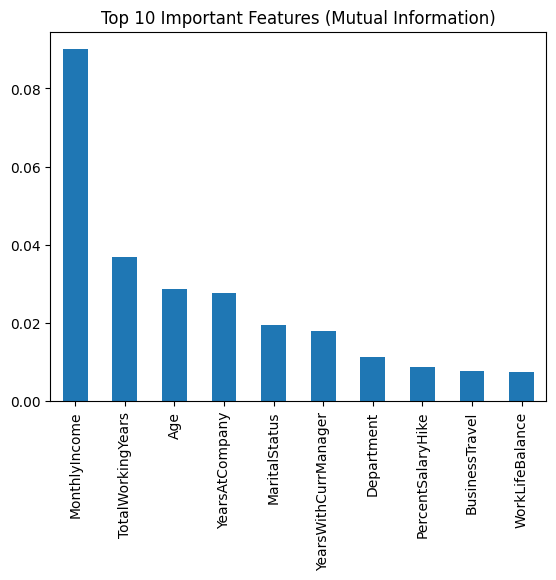

In [17]:

plt.figure()
mi_series.head(10).plot(kind='bar')
plt.title("Top 10 Important Features (Mutual Information)")
plt.show()


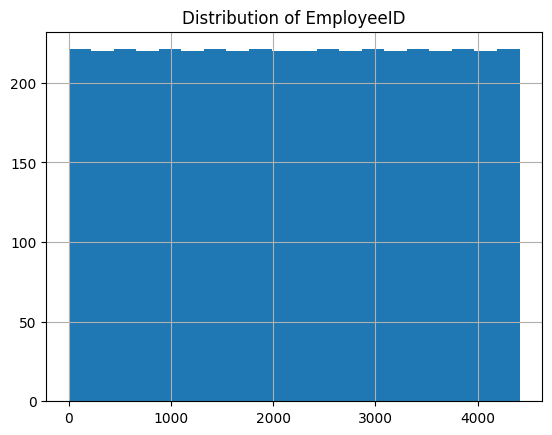

In [18]:

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('Attrition')

plt.figure()
df[num_cols[0]].hist(bins=20)
plt.title(f"Distribution of {num_cols[0]}")
plt.show()


In [19]:

X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:

def objective(trial):
    rf_n = trial.suggest_int("rf_n_estimators", 50, 200)
    xgb_lr = trial.suggest_float("xgb_lr", 0.01, 0.3)
    cat_lr = trial.suggest_float("cat_lr", 0.01, 0.3)

    rf = RandomForestClassifier(n_estimators=rf_n, random_state=42)
    xgb = XGBClassifier(learning_rate=xgb_lr, use_label_encoder=False, eval_metric='logloss')
    cat = CatBoostClassifier(learning_rate=cat_lr, verbose=0)

    model = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
        final_estimator=RandomForestClassifier()
    )

    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

study.best_params


[I 2026-02-24 10:43:05,484] A new study created in memory with name: no-name-275f7c1f-42ac-40b0-8683-2d7fbf488f21
[I 2026-02-24 10:43:36,604] Trial 0 finished with value: 0.9943310657596371 and parameters: {'rf_n_estimators': 183, 'xgb_lr': 0.07187583360221395, 'cat_lr': 0.1688803175135628}. Best is trial 0 with value: 0.9943310657596371.
[I 2026-02-24 10:44:04,083] Trial 1 finished with value: 0.9954648526077098 and parameters: {'rf_n_estimators': 188, 'xgb_lr': 0.2464520086922252, 'cat_lr': 0.04109960252316389}. Best is trial 1 with value: 0.9954648526077098.
[I 2026-02-24 10:44:25,843] Trial 2 finished with value: 0.9965986394557823 and parameters: {'rf_n_estimators': 114, 'xgb_lr': 0.05166122035091718, 'cat_lr': 0.2540665946955671}. Best is trial 2 with value: 0.9965986394557823.
[I 2026-02-24 10:44:52,413] Trial 3 finished with value: 0.9863945578231292 and parameters: {'rf_n_estimators': 183, 'xgb_lr': 0.034575827905857996, 'cat_lr': 0.14616889508962477}. Best is trial 2 with val

{'rf_n_estimators': 114,
 'xgb_lr': 0.05166122035091718,
 'cat_lr': 0.2540665946955671}

In [21]:

best = study.best_params

rf = RandomForestClassifier(n_estimators=best['rf_n_estimators'], random_state=42)
xgb = XGBClassifier(learning_rate=best['xgb_lr'], use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(learning_rate=best['cat_lr'], verbose=0)

stack = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    final_estimator=RandomForestClassifier()
)

stack.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=114,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=No...
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                CatBoostClassifier(learning_rate=0.2540665946955671, verbose=0))],
                   final_estimator=RandomForestClassifier())

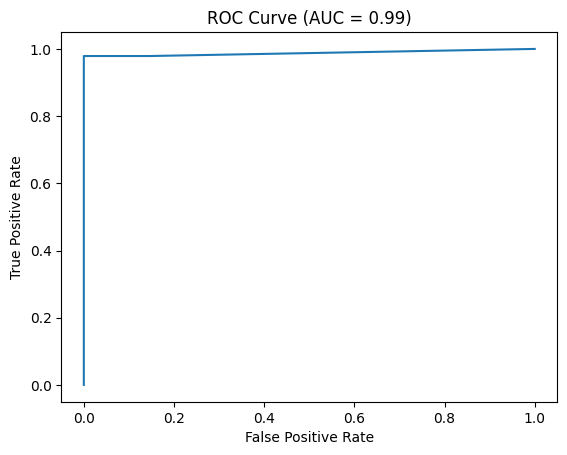

In [22]:

y_prob = stack.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


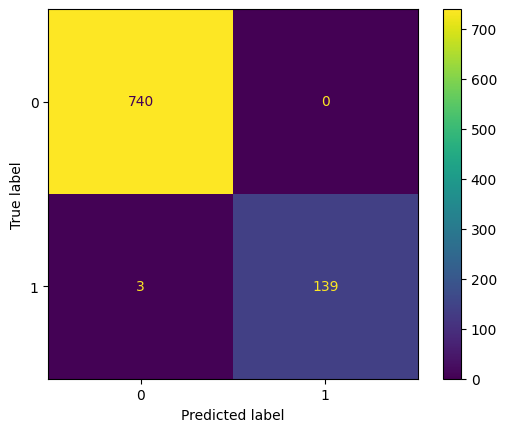

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      0.98      0.99       142

    accuracy                           1.00       882
   macro avg       1.00      0.99      0.99       882
weighted avg       1.00      1.00      1.00       882



In [23]:

y_pred = stack.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))
